#### Import packages and device selection

In [1]:
import os
import re
import cv2
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SIZE = 160
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print("Using device: ", device)

Using device:  cuda


# Dataset Loading and Preprocessing

In [4]:
def sort_files(folder):
    convert_func = lambda x: int(x) if x.isdigit() else x.lower()
    key_func = lambda x: [convert_func(c) for c in re.split('([0-9]+)', x)]
    return sorted(folder, key=key_func)

data_color = []
path = '../data/color'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder):
    img = cv2.imread(path + '/' + file, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    data_color.append(img)
data_color = np.array(data_color)

data_gray = []
path = '../data/gray'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder):
    img = cv2.imread(path + '/' + file, 1)
    img = cv2.resize(img, (SIZE, SIZE))
    data_gray.append(img)
data_gray = np.array(data_gray)

100%|██████████| 7129/7129 [00:06<00:00, 1100.62it/s]


In [6]:
print(data_color.shape, data_gray.shape)

(7129, 160, 160, 3) (7129, 160, 160, 3)


#### Display some samples

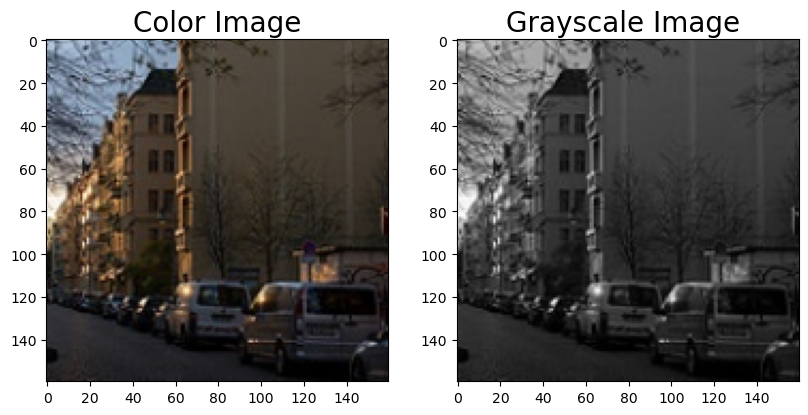

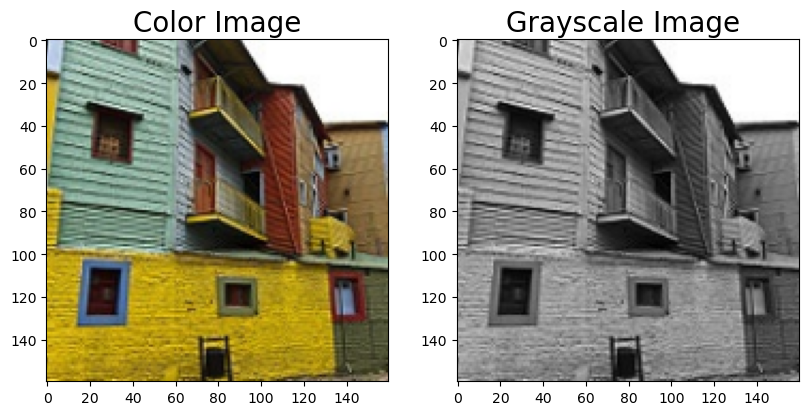

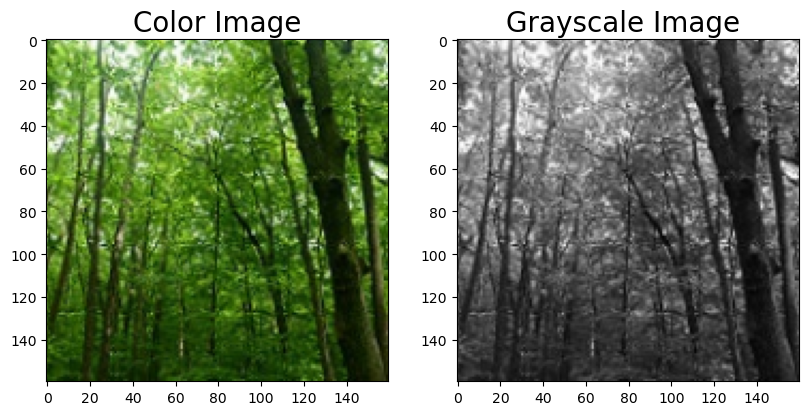

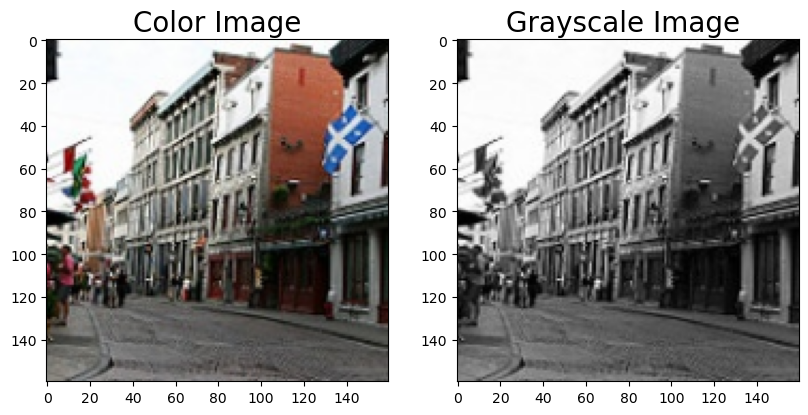

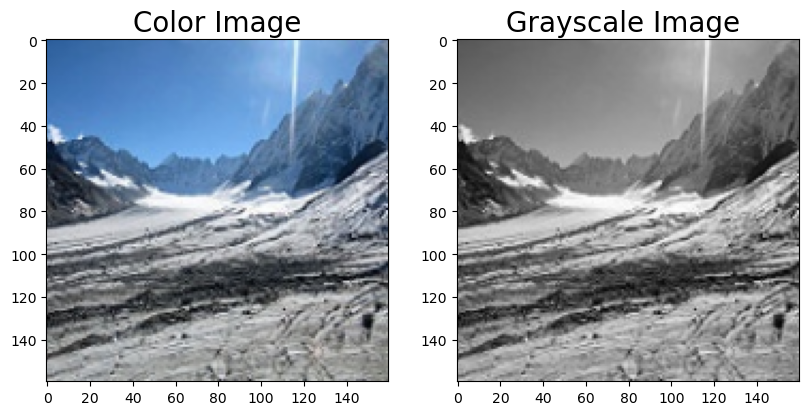

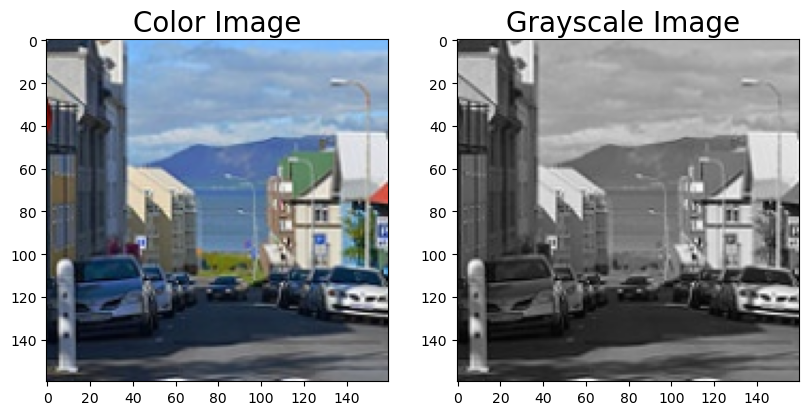

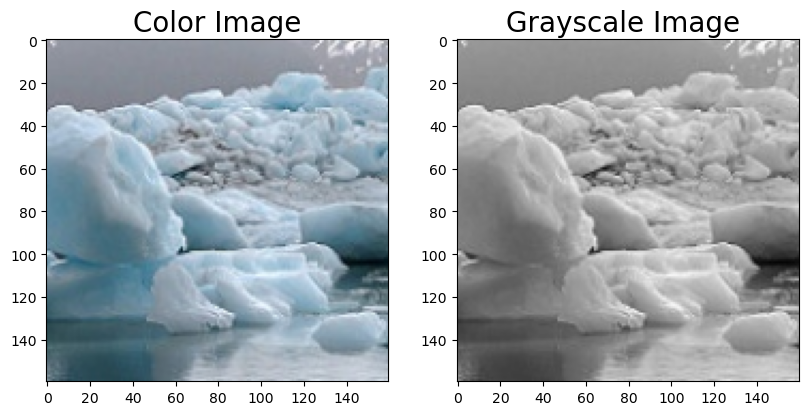

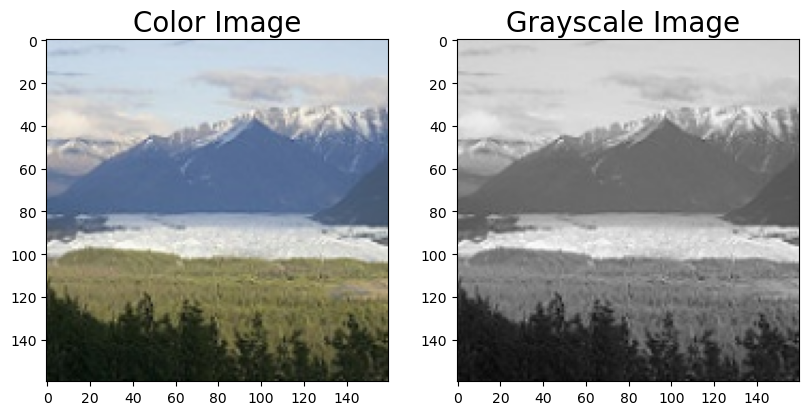

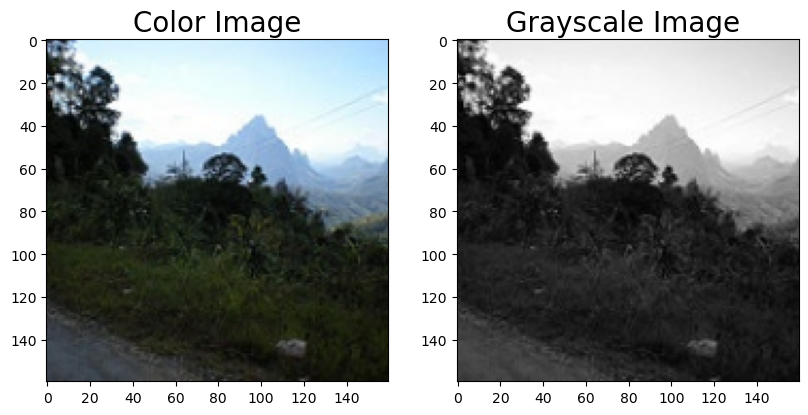

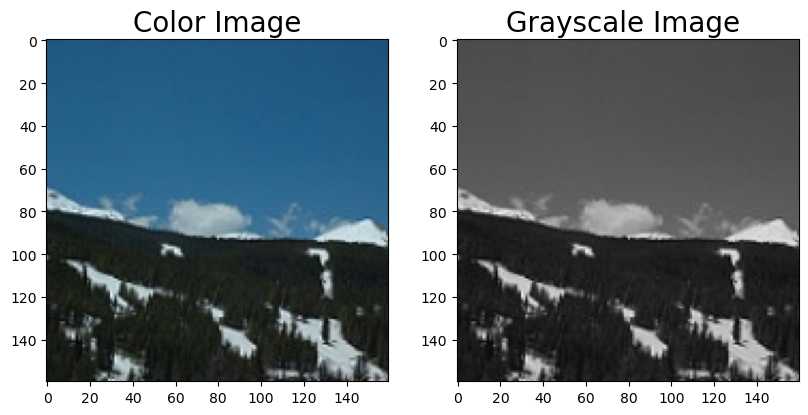

In [5]:
for i in range(10):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Color Image', fontsize=20)
    plt.imshow(data_color[i])
    plt.subplot(1, 3, 2)
    plt.title('Grayscale Image ', fontsize=20)
    plt.imshow(data_gray[i])
    plt.show()
